# Imaging with Stride

In this notebook, we will apply what we have seen previously to image a 2D section of the human breast using full-waveform inversion (FWI) in Stride.

FWI is a tomographic imaging technique, originally developed in geophysics, that solves a local optimisation problem in order to find the acoustic properties (usually speed of sound) of some imaged region. 

Given some data that we have collected or observed $d_{obs}$ and some data that we have modelled numerically $d_{mod}$, FWI solves the problem,

$$
v_p^* = argmin_{v_p} J(v_p, d_{obs}, d_{mod})
$$
$$
s.t.\; \mathbf{L}(d_{mod}, v_p) = \mathbf{0}
$$

to find the speed of sound $v_p$, where $J(v_p, d_{obs}, d_{mod})$ is a scalar loss function and $\mathbf{L}(d_{mod},v_p) = \mathbf{0}$ is a system of PDEs.

Most generally, we use the L2-norm of the distance between $d_{obs}$ and $d_{mod}$ as the loss function, and the acoustic wave equation as the PDE. The problem then becomes,

$$
v_p^* = argmin_{v_p} \left\langle \frac{1}{2} \left( p(v_p) \delta(\mathbf{x}-\mathbf{x}_0) - d_{obs} \right) ^2, 1 \right\rangle
$$
$$
s.t.\; \frac{1}{v_p^2} \frac{\partial^2 p}{\partial t^2} - \nabla^2 p - s = 0
$$

where $\left\langle \alpha, \beta \right\rangle = \int_{t_0}^{t_1}\int_{\Omega} \alpha \cdot \beta d\mathbf{x}^3dt$ for $t \in [t_0, t_1]$ and $\mathbf{x} \in \Omega$, $\delta(x)$ is the sampling Dirac delta, $\mathbf{x}_0$ is the location of receivers in the region, $p$ is the pressure, and $s$ is a source term.

In FWI, we solve this problem by using a local optimisation method like gradient descent, and we calculate the gradient of the problem using the adjoint method or, what is the same, the procedure that we introduced in the first notebook of this tutorial.

## Mosaic runtime

Before we proceed, let's start the Mosaic runtime.

In [1]:
import mosaic

await mosaic.interactive('on', num_workers=2, log_level='info')
runtime = mosaic.runtime()

Listening at <CommsManager object at 139713705284368, uid=monitor, address=CC2416, port=3015, state=connected>HEAD            Listening at <CommsManager object at 139716038173200, uid=head, address=CC2416, port=3018, state=connected>
MONITOR         Listening at <NODE:0 | WORKER:0-2>
WORKER:0:1      (ShotID 1) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      (ShotID 0) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      (ShotID 2) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:1      (ShotID 4) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      AutoTuner: could not perform any 

## Problem definition

Let's start by defining out problem as usual, starting with the spatiotemporal grid.

In [2]:
from stride import Space, Time, Grid
%matplotlib widget

space = Space(shape=(356, 385), extra=(50, 50), absorbing=(40, 40), spacing=0.5e-3)
time = Time(start=0.0e-6, step=0.08e-6, num=2500)

grid = Grid(space, time)

We create the problem object.

In [3]:
from stride import Problem

problem = Problem(name='breast2D', space=space, time=time)

And we start filling it up we our transducers and geometry.

In [4]:
# Create transducers
# the default option will create a single point transducer
problem.transducers.default()

# Create geometry
# a default elliptical geometry will be generated in this case
num_locations = 120
problem.geometry.default('elliptical', num_locations)

We are going to populate our acquisition sequence with 120 shots (one for each location in the geoemtry). During each shot, a different location is going to act as the source and the rest of them are going to act as receivers.

We can easily do this in Stride by calling the `default()` method of the `stride.Acquisitions` object.

In [5]:
from stride.utils import wavelets

# Populate acquisitions with default shots
problem.acquisitions.default()

# Create wavelets
f_centre = 0.50e6
n_cycles = 3

for shot in problem.acquisitions.shots:
    shot.wavelets.data[0, :] = wavelets.tone_burst(f_centre, n_cycles, time.num, time.step)

Now, let's load our breast model.

In [6]:
from stride import ScalarField

# Create medium
vp_true = ScalarField(name='vp', grid=grid)
vp_true.load('../examples/breast2D/data/anastasio2D-TrueModel.h5')

problem.medium.add(vp_true)

To get a plot of all components of the problem together, we can call the utility function `plot()` on the problem object.

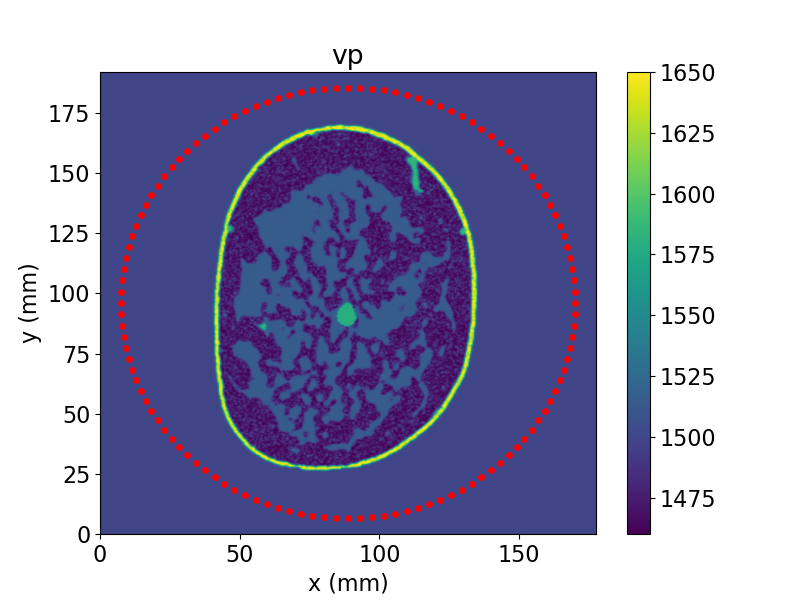

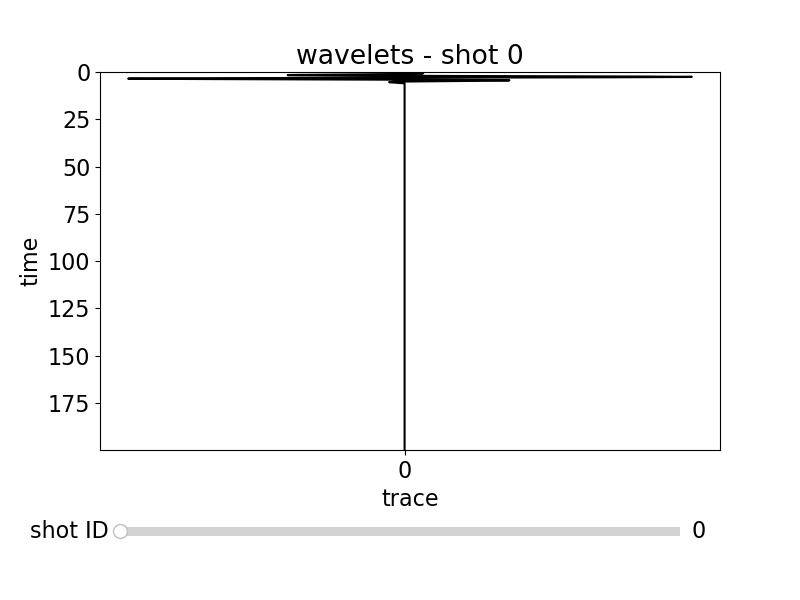

In [7]:
# Plot all components of the problem
problem.plot()

## Modelling operator

Once we have generated our problem, we can create a PDE on which to run our forward problem. In this case, we choose the isotropic acoustic wave equation.

We instantiate our PDE using `remote(len=<num>)` so that instances of the PDE are created in the workers for remote execution. We choose `len=runtime.num_workers` so that one instance is created in each available worker.

In [8]:
from stride import IsoAcousticDevito

pde = IsoAcousticDevito.remote(grid=problem.grid, len=runtime.num_workers)

## Forward problem - Generating observed data

Before we can proceed with the imaging bit, we need to simulate the acquisition of some observed data.

Here, we will exploit the parallelisation capabilities of Mosaic to run different shots in parallel in each available worker. We do this with an asynchronous for loop using `@runtime.async_for(<iterable>)`. In the previous code section, the async function `loop()` is called as many times as there are shots in the acquisitions and, for each shot, it is assigned a worker.

HEAD            Giving shot 0 to worker:0:0
HEAD            Giving shot 1 to worker:0:1
HEAD            Shot 1 retrieved
HEAD            Retrieved traces for shot 1
HEAD            Giving shot 2 to worker:0:1
HEAD            Shot 0 retrieved
HEAD            Retrieved traces for shot 0
HEAD            Giving shot 3 to worker:0:0
HEAD            Shot 2 retrieved
HEAD            Retrieved traces for shot 2
HEAD            Giving shot 4 to worker:0:1
HEAD            Shot 4 retrieved
HEAD            Retrieved traces for shot 4
HEAD            Giving shot 5 to worker:0:1
HEAD            Shot 5 retrieved
HEAD            Retrieved traces for shot 5
HEAD            Giving shot 6 to worker:0:1
HEAD            Shot 6 retrieved
HEAD            Retrieved traces for shot 6
HEAD            Giving shot 7 to worker:0:1
HEAD            Shot 7 retrieved
HEAD            Retrieved traces for shot 7
HEAD            Giving shot 8 to worker:0:1
HEAD            Shot 8 retrieved
HEAD            Retrieved traces

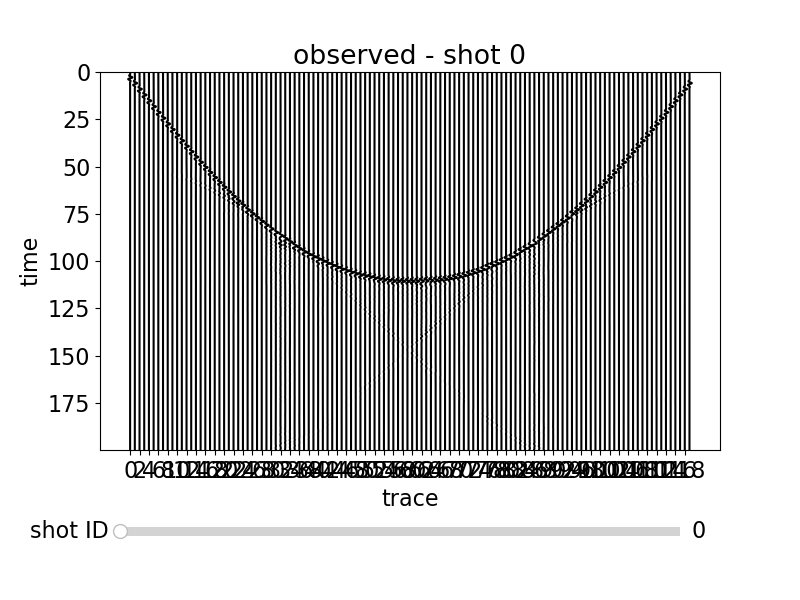

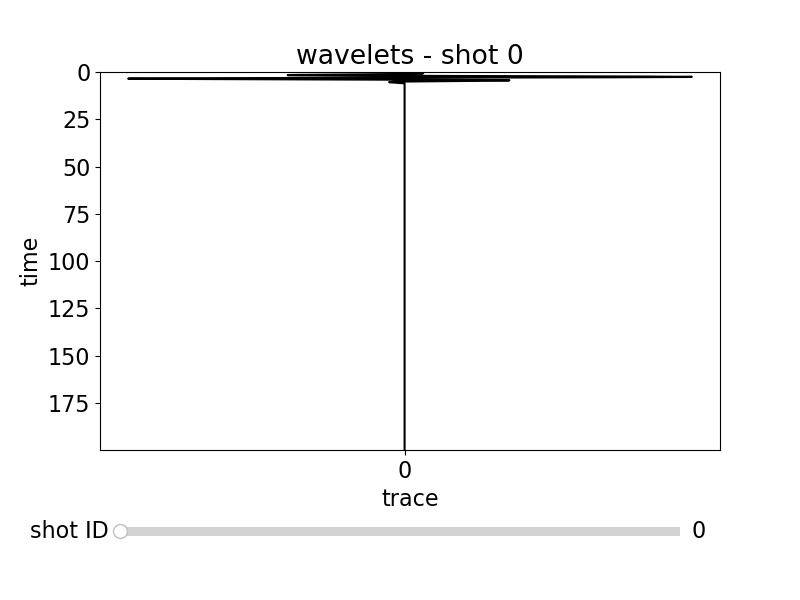

In [9]:
# Get all remaining shot IDs
shot_ids = problem.acquisitions.remaining_shot_ids

# Run an asynchronous loop across all shot IDs
@runtime.async_for(shot_ids)
async def loop(worker, shot_id):
    runtime.logger.info('Giving shot %d to %s' % (shot_id, worker.uid))

    # Fetch one sub-problem corresponding to a shot ID
    sub_problem = problem.sub_problem(shot_id)
    
    # Access the source wavelets of this shot
    wavelets = sub_problem.shot.wavelets
    
    # Execute the PDE forward
    traces = await pde(wavelets, vp_true,
                       problem=sub_problem,
                       runtime=worker).result()

    runtime.logger.info('Shot %d retrieved' % sub_problem.shot_id)

    # Store the retrieved traces into the shot
    shot = problem.acquisitions.get(shot_id)
    shot.observed.data[:] = traces.data

    runtime.logger.info('Retrieved traces for shot %d' % sub_problem.shot_id)

# Because this is an asynchronous loop, it needs to be awaited 
_ = await loop

# Plot the result
_ = problem.acquisitions.plot()

Because the loop we just ran is a very common piece of code, we can obtain the same result by running the utility function `forward()`:

In [10]:
from stride import forward

# Run default forward workflow
# await forward(problem, pde, vp_true, dump=False)  # uncomment to run using utility function

## Starting model

Before we can proceed with the imaging process, we need to determine a starting point for our inversion, a starting model.

In [11]:
vp = ScalarField.parameter(name='vp', grid=grid, needs_grad=True)
vp.fill(1500.)

problem.medium.add(vp)

Unlike our forward example, the speed-of-sound field is unknown to us at this point. So, we define our starting guess for the speed of sound to be homogeneous with a value of 1500 m/s. Because we are going to run our inversion with respect to `vp`, we also define the field with `needs_grad=True`. That will instruct Stride to calculate the gradient of this variable when running the optimisation loop.

You can also see that the field has now been instantiated using `parameter()`. This will turn `vp` into a remotely addressable object. What this means is that, as `vp` travels through our Mosaic network, it will always keep a reference to its original object here in our code. This will effectively allow us to accumulate the gradients calculated across different workers into a single local buffer.

## Imaging operators

Apart from our PDE operator, which we have already defined above, we will need to define an operator for our loss function:

In [12]:
from stride import L2DistanceLoss 

loss = L2DistanceLoss.remote(len=runtime.num_workers)

We will also need some operators to proprocess the source wavelents and the modelled and observed data traces:

In [13]:
from stride import ProcessWavelets, ProcessObserved, ProcessWaveletsObserved, ProcessTraces

process_wavelets = ProcessWavelets.remote(len=runtime.num_workers)
process_observed = ProcessObserved.remote(len=runtime.num_workers)
process_wavelets_observed = ProcessWaveletsObserved.remote(len=runtime.num_workers)
process_traces = ProcessTraces.remote(len=runtime.num_workers)

Finally, we will need an optimiser to update the speed of sound model after each iteration. In this case, we use gradient descent.

In [14]:
from stride import GradientDescent, ProcessGlobalGradient, ProcessModelIteration

step_size = 10
process_grad = ProcessGlobalGradient()
process_model = ProcessModelIteration(min=1400., max=1700.)

optimiser = GradientDescent(vp, step_size=step_size,
                            process_grad=process_grad,
                            process_model=process_model)

You can see that we have also provided to the optimiser some pre-defined processing steps. These will be used to prepare the gradient before updating the variable, and to process the variable after the update. 

Among other things, these processing steps will normalise and smooth the gradient, and will clip the speed of sound of the updated model between 1400 m/s and 1700 m/s.

## Inverse problem - Estimating speed of sound

We can now proceed to solve the inverse problem, that is finding the speed of sound that explains the data that we have generated above.

To obtain a better posed optimisation, we use a multi-scale approach. We will start our inversion by using only low frequencies to construct our model. As the inversion progresses, we will add higher frequencies until we reach the maximum desired level of detail.

We can do this by dividing our optimisation in `Block`s and specifying a maximum frequency. Each `Block` will run for a number of specified iterations.

During each iteration, only a subset of the shots will be used by defining the `select_shots` field. In this case, 15 shots will be used for each iteration, and they will be selected randomly without replacement.

HEAD            Starting iteration 1 (out of 4), block 1 (out of 2)
HEAD            Giving shot 16 to worker:0:0
HEAD            Giving shot 17 to worker:0:1
HEAD            Functional value for shot 17: loss 2.008485e+00 for shot 17
HEAD            Functional value for shot 16: loss 1.792513e+00 for shot 16
HEAD            Retrieved gradient for shot 17
HEAD            Giving shot 27 to worker:0:1
HEAD            Functional value for shot 27: loss 2.335841e+00 for shot 27
HEAD            Retrieved gradient for shot 27
HEAD            Giving shot 40 to worker:0:1
HEAD            Functional value for shot 40: loss 1.678519e+00 for shot 40
HEAD            Retrieved gradient for shot 40
HEAD            Giving shot 45 to worker:0:1
HEAD            Functional value for shot 45: loss 1.577361e+00 for shot 45
HEAD            Retrieved gradient for shot 45
HEAD            Giving shot 61 to worker:0:1
HEAD            Functional value for shot 61: loss 1.375144e+00 for shot 61
HEAD            Re

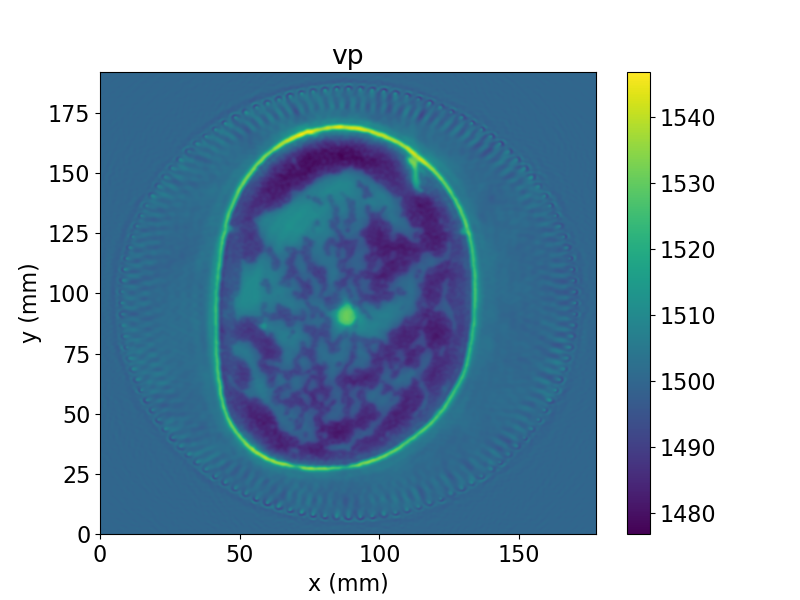

<Axes: title={'center': 'vp'}, xlabel='x (mm)', ylabel='y (mm)'>

WORKER:0:1      (ShotID 35) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 35) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.64 s
WORKER:0:0      Global performance: [OI=1.79, 42.22 GFlops/s, 0.87 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<2499,456,485> ran in 0.56 s [OI=2.82, 45.97 GFlops/s, 1.00 GPts/s]
WORKER:0:0        * section1<<2499,120,2,2>,<2499,120,2,2>> ran in 0.02 s [OI=6.00, 4.92 GFlops/s, 0.09 GPts/s]
WORKER:0:0        * section2<2499,376,405> ran in 0.08 s [OI=0.25, 21.42 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced-fsg] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 29) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 29
HEAD            Giving shot 36 to worker:0:0
WORKER:0:0      (ShotID 36) Preparing to run state for shot
WORKER:0:0      (ShotID 36)

WORKER:0:1      AutoTuner: could not perform any runs
HEAD            Functional value for shot 52: loss 6.635887e-01 for shot 52
WORKER:0:0      (ShotID 52) Preparing to run adjoint for shot
WORKER:0:0      (ShotID 52) Running adjoint equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.48 s
WORKER:0:1      Global performance: [OI=2.06, 57.60 GFlops/s, 1.16 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<2499,456,485> ran in 0.43 s [OI=2.82, 59.64 GFlops/s, 1.30 GPts/s]
WORKER:0:1        * section1<<2499,1,2,2>,<2499,1,2,2>> ran in 0.01 s [OI=5.80, 0.14 GFlops/s, 0.01 GPts/s]
WORKER:0:1        * section2<<2499,120>,<2499,120,2,2>> ran in 0.01 s [OI=1.84, 2.54 GFlops/s, 0.00 GPts/s]
WORKER:0:1        * section3<2499,456,485> ran in 0.04 s [OI=0.50, 58.17 GFlops/s, 14.55 GPts/s]
WORKER:0:1      Performance[mode=advanced-fsg] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1    

WORKER:0:1      (ShotID 105) Spatial grid spacing (0.500 mm | 4.139 PPW) is higher than dispersion limit (0.414 mm | 5.000 PPW)
WORKER:0:1      (ShotID 105) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.146 μs)
WORKER:0:1      (ShotID 105) Selected undersampling level 4
WORKER:0:1      (ShotID 105) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 105) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_state` ran in 0.63 s
WORKER:0:0      Global performance: [OI=2.06, 43.89 GFlops/s, 0.88 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<2499,456,485> ran in 0.58 s [OI=2.82, 44.53 GFlops/s, 0.97 GPts/s]
WORKER:0:0        * section1<<2499,1,2,2>,<2499,1,2,2>> ran in 0.01 s [OI=5.80, 0.12 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120,2,2>> ran in 0.01 s [OI=1.84, 2.18 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section3<2499,456,485> ran in 0.05 s [

WORKER:0:0      Local performance:
WORKER:0:0        * section0<2499,456,485> ran in 0.49 s [OI=2.82, 52.48 GFlops/s, 1.15 GPts/s]
WORKER:0:0        * section1<<2499,1,2,2>,<2499,1,2,2>> ran in 0.01 s [OI=5.80, 0.14 GFlops/s, 0.01 GPts/s]
WORKER:0:0        * section2<<2499,120>,<2499,120,2,2>> ran in 0.01 s [OI=1.84, 2.48 GFlops/s, 0.00 GPts/s]
WORKER:0:0        * section3<2499,456,485> ran in 0.05 s [OI=0.50, 54.57 GFlops/s, 13.65 GPts/s]
WORKER:0:0      Performance[mode=advanced-fsg] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 4) Completed state equation run for shot
WORKER:0:1      Operator `acoustic_iso_state` ran in 0.63 s
WORKER:0:1      Global performance: [OI=2.06, 43.89 GFlops/s, 0.88 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<2499,456,485> ran in 0.58 s [OI=2.82, 44.52 GFlops/s, 0.97 GPts/s]
WORKER:0:1        * section1<<2499,1,2,2>,<2499,1,2,2>> ran in 0.01 s [OI=5.80, 0.14 GFlops/s, 0.01 GPts/s]
WORKER:0:1        

WORKER:0:1        * section2<2499,376,405> ran in 0.08 s [OI=0.25, 20.39 GFlops/s, 0.00 GPts/s]
WORKER:0:1      Performance[mode=advanced-fsg] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 34) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 34
HEAD            Giving shot 40 to worker:0:1
WORKER:0:1      (ShotID 40) Preparing to run state for shot
WORKER:0:1      (ShotID 40) Estimated bandwidth for the propagated wavelet 0.245-0.715 MHz
WORKER:0:1      (ShotID 40) Spatial grid spacing (0.500 mm | 4.125 PPW) is higher than dispersion limit (0.412 mm | 5.000 PPW)
WORKER:0:1      (ShotID 40) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.146 μs)
WORKER:0:1      (ShotID 40) Selected undersampling level 4
WORKER:0:1      (ShotID 40) Selected time stepping scheme OT2
WORKER:0:1      (ShotID 40) Running state equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_

WORKER:0:0      (ShotID 42) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 42
HEAD            Giving shot 46 to worker:0:0
WORKER:0:0      (ShotID 46) Preparing to run state for shot
WORKER:0:0      (ShotID 46) Estimated bandwidth for the propagated wavelet 0.245-0.715 MHz
WORKER:0:0      (ShotID 46) Spatial grid spacing (0.500 mm | 4.125 PPW) is higher than dispersion limit (0.412 mm | 5.000 PPW)
WORKER:0:0      (ShotID 46) Time grid spacing (0.080 μs | 24%) is below OT2 limit (0.146 μs)
WORKER:0:0      (ShotID 46) Selected undersampling level 4
WORKER:0:0      (ShotID 46) Selected time stepping scheme OT2
WORKER:0:0      (ShotID 46) Running state equation for shot
WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:1      Operator `acoustic_iso_adjoint` ran in 0.70 s
WORKER:0:1      Global performance: [OI=1.79, 38.60 GFlops/s, 0.79 GPts/s]
WORKER:0:1      Local performance:
WORKER:0:1        * section0<2499,456,485> ran in 0.61 s [OI=2

WORKER:0:1        * section3<2499,456,485> ran in 0.04 s [OI=0.50, 58.49 GFlops/s, 14.63 GPts/s]
WORKER:0:1      Performance[mode=advanced-fsg] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:1      (ShotID 77) Completed state equation run for shot
HEAD            Functional value for shot 77: loss 1.185848e+00 for shot 77
WORKER:0:1      (ShotID 77) Preparing to run adjoint for shot
WORKER:0:1      (ShotID 77) Running adjoint equation for shot
WORKER:0:1      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.64 s
WORKER:0:0      Global performance: [OI=1.79, 42.22 GFlops/s, 0.87 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<2499,456,485> ran in 0.55 s [OI=2.82, 46.59 GFlops/s, 1.02 GPts/s]
WORKER:0:0        * section1<<2499,120,2,2>,<2499,120,2,2>> ran in 0.02 s [OI=6.00, 4.91 GFlops/s, 0.09 GPts/s]
WORKER:0:0        * section2<2499,376,405> ran in 0.08 s [OI=0.25, 21.13 GFlops/s, 0.00 GPts/s]
WORKER:0

WORKER:0:0      AutoTuner: could not perform any runs
WORKER:0:0      Operator `acoustic_iso_adjoint` ran in 0.46 s
WORKER:0:0      Global performance: [OI=1.79, 58.74 GFlops/s, 1.21 GPts/s]
WORKER:0:0      Local performance:
WORKER:0:0        * section0<2499,456,485> ran in 0.41 s [OI=2.82, 63.00 GFlops/s, 1.37 GPts/s]
WORKER:0:0        * section1<<2499,120,2,2>,<2499,120,2,2>> ran in 0.02 s [OI=6.00, 6.41 GFlops/s, 0.11 GPts/s]
WORKER:0:0        * section2<2499,376,405> ran in 0.04 s [OI=0.25, 39.54 GFlops/s, 0.00 GPts/s]
WORKER:0:0      Performance[mode=advanced-fsg] arguments: {'nthreads': 3, 'nthreads_nonaffine': 3}
WORKER:0:0      (ShotID 115) Completed adjoint equation run for shot
HEAD            Retrieved gradient for shot 115
MONITOR         Pending barrier tasks 1
HEAD            Updating variable vp,
HEAD            	 grad before processing in range [-5.321078e-04, 1.947885e-04]
HEAD            	 grad after processing in range [-1.000000e+00, 3.660839e-01]
HEAD            	

<IPython.core.display.Javascript object>


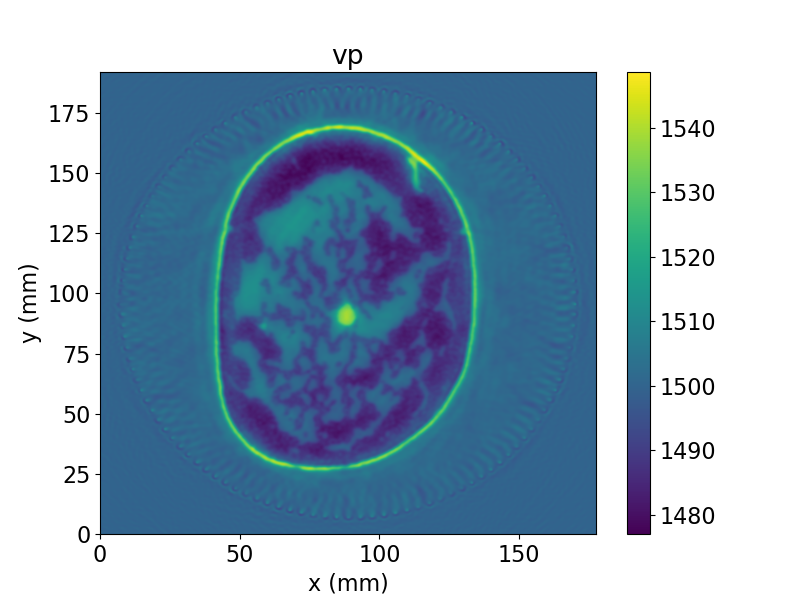

<AxesSubplot:title={'center':'vp'}, xlabel='x (mm)', ylabel='y (mm)'>

In [15]:
from stride import OptimisationLoop

# Clear the previous Devito operators
await pde.clear_operators()

optimisation_loop = OptimisationLoop()

# Specify a series of frequency bands, which we will introduce gradually 
# into the inversion in order to better condition it
max_freqs = [0.3e6, 0.4e6]

num_blocks = len(max_freqs)
num_iters = 4

# Start iterating over each block in the optimisation
for block, f_max in optimisation_loop.blocks(num_blocks, max_freqs):

    # Proceed through every iteration in the block
    for iteration in block.iterations(num_iters):
        runtime.logger.info('Starting iteration %d (out of %d), '
                            'block %d (out of %d)' %
                            (iteration.id+1, block.num_iterations, block.id+1,
                             optimisation_loop.num_blocks))

        # Select some shots for this iteration
        shot_ids = problem.acquisitions.select_shot_ids(num=15, randomly=True)

        # Clear the gradient buffers of the variable
        vp.clear_grad()

        # Asynchronously loop over all the selected shot IDs
        @runtime.async_for(shot_ids)
        async def loop(worker, shot_id):
            runtime.logger.info('Giving shot %d to %s' % (shot_id, worker.uid))

            # Fetch one sub-problem corresponding to the shot ID
            sub_problem = problem.sub_problem(shot_id)
            wavelets = sub_problem.shot.wavelets
            observed = sub_problem.shot.observed

            # Pre-process the wavelets and observed
            wavelets = process_wavelets(wavelets, f_max=f_max, filter_relaxation=0.75, runtime=worker)
            observed = process_observed(observed, f_max=f_max, filter_relaxation=0.75, runtime=worker)
            processed = process_wavelets_observed(wavelets, observed, f_max=f_max, runtime=worker)
            wavelets = processed.outputs[0]
            observed = processed.outputs[1]
            
            # Execute the PDE forward
            modelled = pde(wavelets, vp, problem=sub_problem, runtime=worker)

            # Pre-process the modelled and observed traces
            traces = process_traces(modelled, observed, f_max=f_max, filter_relaxation=0.75, runtime=worker)
            # and use these pre-processed versions to calculate the
            # value of the loss_freq function
            fun = await loss(traces.outputs[0], traces.outputs[1],
                             problem=sub_problem, runtime=worker).result()

            iteration.add_loss(fun)
            runtime.logger.info('Functional value for shot %d: %s' % (shot_id, fun))

            # Now, we can calculate the gradient by executing the adjoint of the
            # forward process
            await fun.adjoint()

            runtime.logger.info('Retrieved gradient for shot %d' % sub_problem.shot_id)

        # Because this is an async loop, it needs to be awaited    
        _ = await loop
        # Update the vp with the calculated gradient by taking a step with the optimiser
        await optimiser.step()

        runtime.logger.info('Done iteration %d (out of %d), '
                            'block %d (out of %d) - Total loss_freq %e' %
                            (iteration.id+1, block.num_iterations, block.id+1,
                             optimisation_loop.num_blocks, iteration.total_loss))
        runtime.logger.info('====================================================================')

# Plot the vp afterwards   
vp.plot()

As was the case for the forward example, we can obtain the same result by using a utility function that will run the default inversion workflow using `adjoint`:

In [16]:
# uncomment to run using utility function
# for block, freq in optimisation_loop.blocks(num_blocks, max_freqs):
#     await adjoint(problem, pde, loss,
#                   optimisation_loop, optimiser, vp,
#                   num_iters=num_iters,
#                   select_shots=dict(num=15, randomly=True),
#                   f_max=freq)

# vp.plot()

Before closing, we should tear down the mosaic runtime:

In [17]:
await mosaic.interactive('off')